# Final Project 

This project will analyze my Spotify user data and weather information over the span of July to September of this year. I chose this data because I enjoy listening to music and it would be fun to see a breakdown of my information aside from the annual Spotify wrapped. Additionally, I chose this so that I could try and spot a pattern from my listening habits. The tables of Spotify data include track name, time played, artist, and date played collected from my usage of the app. The weather API will return a CSV that contains dates and the weather data for that given date collected by the Spokane weather station. In this project, we will only use average daily temperature since most of the other attributes are irrelevant and have many missing values. For classification, I will classify the genres of each artist and make predictions upon it. 

In [1]:
import importlib 
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base64
import utilsapi
importlib.reload(utilsapi)  #we don't have to start the kernel every time. 
import scipy.stats as stats
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import csv
from sklearn.preprocessing import MinMaxScaler

#### Cleaning Personal Spotify Data

Once I made the request to retrieve my data, Spotify makes available a folder full of user data and information that I can open and read in. The data comes in the form of JSON files. Each instance comes with endtime, aritst name, song, and miliseconds played attributes. Below I read the JSON and split the endTime attribute from the file becuase it had the time and date within the same column. I split this into two in order to give date its own column and later merge on it. The rest of the inofrmation such as trackName, artistName, and miliSecond played are then appended to a new DataFrame and the values were split are appended to it as well. Lastly, I take the miliseconds played column and divide each value to minutes by dividing the instance by 60000.

In [2]:
spotify_data = pd.read_json("StreamingHistory1.json")
time_data = spotify_data['endTime']
dates_list = []
times_list = []
for item in time_data: #split the string and store them into two different variables. 
    values = item.split(' ')
    dates_list.append(values[0])
    times_list.append(values[1])
d = {'dates': dates_list, 'times': times_list}
split_df = pd.DataFrame(d)
extract_df = pd.DataFrame([spotify_data["artistName"], spotify_data["trackName"], spotify_data["msPlayed"]])
spotify_data = spotify_data.drop(columns=['endTime'])
final_df = pd.concat([split_df, spotify_data], axis=1, ignore_index=True)
mlseconds = final_df[4]
minutes = []
for i in mlseconds:
    minutes.append(round(i/60000, 2))
final_df['minutes'] = minutes
final_df = final_df.drop(columns=[4])

final_df.to_csv("final.csv")

##### Summing Daily Listening Time 

In this section, we sum the daily listening time. We do this by taking the duration that we listen to each time and adding it together to make the total listening time for a given day. It is critical that the date is split away and made into its own column because this is the common attribute that both datasets hold. 

In [3]:
time_data['date'] = final_df[0] 
time_data['minutes'] = final_df['minutes']
dates = []
total_minutes = []
prev_date = time_data['date'][0]
current_date = ""
total_time = 0

for i in range(len(time_data['date'])) :
    current_date = time_data['date'][i]
    if current_date == prev_date:
        total_time = round(total_time + time_data['minutes'][i], 2)
    if current_date != prev_date:
        dates.append(prev_date)
        total_minutes.append(total_time)
        total_time = 0
    prev_date = current_date
dates.append(current_date)
total_minutes.append(total_time)

daily_time = pd.DataFrame(dates, columns=['date'])
daily_time['total_time'] = total_minutes
daily_time.to_csv("dailytime.csv")
print(daily_time.describe())

       total_time
count   83.000000
mean   135.069157
std    133.970363
min      0.000000
25%     36.420000
50%     88.620000
75%    189.530000
max    607.160000


Based on the daily time that we have split and appended onto the DataFrame, calling the describe function gives us the results we see above. It's interesting to see that the most time I spent listening to music in one day was 600 minutes which is 10 hours. It is also worth noting that the average daily time spent listening to mmusic was 135 minutes or 2 hours and 15 minutes. 

### Weather API Request and Cleaning 

Next, we make a request to the weather API in order to retrieve Spokane weather data for the span of our objects. After making the request, I make a DataFrame full of the most important attibutes from the response. I also drop any attributes that have too many missing values. Any columns that are kept and contain NaNs will get their instances front filled and then backfilled in the case that there are empty instances at the end of the response.  

In [4]:
# obtain daily weather data for 01/01/2021 until 10/20/2021 (I used the 20th because any later date made it error out)
daily_url = "https://meteostat.p.rapidapi.com/stations/daily"
daily_url += "?station=" + "KSFF0"
daily_url += "&start=2021-07-01&end=2021-09-29&units=imperial"
daily_headers = {"x-rapidapi-key": utilsapi.weather}
response = requests.get(url=daily_url, headers=daily_headers)
json_obj = json.loads(response.text)
data_obj = json_obj['data']
#load data_obj into a data frame and set the headers. 
df = pd.DataFrame(data_obj, columns= ['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'])
#replace values that are missing with np.nan so I can later use .isnull().mean()
df = df.fillna(value=np.nan)
# takes the average of isnulls within the column and creates a new dataframe with columns that only contain less than 75% of NaNs
df = df[df.columns[(df.isnull().mean() < 0.75)]]
#cleans up the data frame by filling NaNs 
df = df.interpolate(method='linear')
df = df.ffill()
df = df.bfill()
# prints out the cleaned data to a csv
df.to_csv("Spokane_daily_weather_cleaned.csv")


##### Grabbing Artists from Personal Data

In this next part, we take the artist column of the DataFrame and we iterate through it to make a list full of all the artists that I listen to. I do this becuase in order to make the requests to the Spotify API and keep VSCode from crashing, I can't make requests for all 4500 instances in my DataFrame. So this approach where I only make requests once per every artist is far more convenient and greatly reduces the chance of error. At the end of this code cell however, it is seen tat I removed an artist form the list. I decided to go in and remove this artist becuase the JSON response did not have an item in it at all. Therefore, there was nothing for me to extract from it. Initially, I did not intend on excluding any of the artists from my list. However, removing this artist did not make any significant change to my data because I listened to this artist at most 2 times. 

In [5]:
artists = []
prev_artist = final_df[2][0]
index = 0;

for i in final_df[2]:
    if i in artists:
        continue
    else:
        artists.append(i)

artist = artists.remove("MakFlakes ") #this artist had to be removed because it returned a response with no item[0] (as if item didn't exist)
#this won't effect my data too much because I don't even remember who this artist is 

### Spotify API Requests for Artist Genre 

The next step is to make requests for genres of each artist. This code is taken from the example done by Gina Sprint in class. This entire block grabs the access token and uses it when iterating through the artist names. Once I get a JSON response, I parse through the data to find the genre and return it to store inside of a list. 

In [6]:
genres = []

client_ID = utilsapi.CID_spotify
client_secret = utilsapi.CS_spotify

endpoint = "https://accounts.spotify.com/api/token"
API_endpoint = "https://api.spotify.com/v1/search"

def grab_accesstoken():
    message = client_ID + ":" + client_secret
    message_bytes = message.encode("ascii")
    base64_bytes = base64.b64encode(message_bytes)
    encoded_client_details = base64_bytes.decode("ascii")
    headers = {"Authorization": "Basic " + encoded_client_details}              
    body = {"grant_type": "client_credentials"}
    response = requests.post(url=endpoint, headers=headers, data=body)
    json_object = json.loads(response.text)
    return json_object["access_token"]

def make_request(access_token, full_url):
    headers = {"Accept": "application/json",
                "Content-Type": "application/json",
                "Authorization": "Bearer " + access_token}
    response = requests.get(url= full_url, headers=headers)
    json_object = json.loads(response.text)
    return json_object

def search_request(access_token, search_term, search_type):
    search_term = requests.utils.quote(search_term)
    search_type = requests.utils.quote(search_type)
    url = API_endpoint + "?q=" + search_term
    url += "&type=" + search_type
    print(url)
    json_obj = make_request(access_token, url)
    return json_obj

def get_genres(json_obj):
    artists = json_obj["artists"]
    items = artists["items"]
    if not items[0]:
        exit
    else:
        first_artist_item = items[0] # TODO: are they sorted by match confidence/popularity?
        genre = first_artist_item["genres"]
        return genre

access_token = grab_accesstoken()

for i in artists:
    json_obj = search_request(access_token, i, "artist")
    genre = get_genres(json_obj)
    if not genre:
        genres.append("NA")
    else:
        genres.append(genre)

https://api.spotify.com/v1/search?q=Bring%20Me%20The%20Horizon&type=artist
https://api.spotify.com/v1/search?q=Verzache&type=artist
https://api.spotify.com/v1/search?q=Rich%20Brian&type=artist
https://api.spotify.com/v1/search?q=Post%20Malone&type=artist
https://api.spotify.com/v1/search?q=Joji&type=artist
https://api.spotify.com/v1/search?q=Krys%20Talk&type=artist
https://api.spotify.com/v1/search?q=DPR%20LIVE&type=artist
https://api.spotify.com/v1/search?q=Bagger%20boy&type=artist
https://api.spotify.com/v1/search?q=Billy%20Marchiafava&type=artist
https://api.spotify.com/v1/search?q=The%20Weeknd&type=artist
https://api.spotify.com/v1/search?q=SoulChef&type=artist
https://api.spotify.com/v1/search?q=Topaz%20Jones&type=artist
https://api.spotify.com/v1/search?q=Frank%20Ocean&type=artist
https://api.spotify.com/v1/search?q=Khalid&type=artist
https://api.spotify.com/v1/search?q=Aaron%20May&type=artist
https://api.spotify.com/v1/search?q=Childish%20Gambino&type=artist
https://api.spotify.

in the follwoing cell we place the genres into a list. The request returns several genres per artist so I only take the first genre since it's the artist's main genre. 

In [21]:
cleaned_genres = []
for i in genres:
    if i == "NA":
        cleaned_genres.append("NA")
    else:
        cleaned_genres.append(i[0])


Next we go through the artist column and fill a list that consists of the corresponding genre for each artist. 

In [22]:
final_artists = pd.DataFrame(artists, columns=["artist"])
final_artists['genre'] = cleaned_genres 
print(final_artists)

temp_df = final_df[2]
temp_genres = []
for i in temp_df:
    if i in artists:
        index = artists.index(i)
        temp_genres.append(cleaned_genres[index])
    else: 
        temp_genres.append("NA")

final_df['genres'] = temp_genres

                   artist               genre
0    Bring Me The Horizon   melodic metalcore
1                Verzache           lo-fi rap
2              Rich Brian  indonesian hip hop
3             Post Malone             dfw rap
4                    Joji     alternative r&b
..                    ...                 ...
461                     Q        classic rock
462                Giveon                 pop
463                Masego                  NA
464                   UMI     alternative r&b
465                 dhruv           chill r&b

[466 rows x 2 columns]


Next I would like to see my top 5 genres that I listen to. So for this I take the genres attribute in the DataFrame and count the instances of each genre in the column. Then I preceded to place both the unique genres and thier counts into a DataFrame and sorted the DataFrame by value. I then take the 5 genres with the most instances and create a pie chart for them. It seems that I listen to k-pop the most followed by "adult standards", r&b, pop, and Latin American music. It was interesting to see that my top 5 genres spanned over at least 3 languages. 

              genre  count
6             k-pop    433
21  adult standards    362
4   alternative r&b    265
32        dance pop    254
18            latin    187


([<matplotlib.patches.Wedge at 0x1a998174a00>,
 [Text(0.678355904798632, 0.8659291347592074, 'k-pop'),
  Text(-0.9252657168897265, 0.5948809571238104, 'adult standards'),
  Text(-0.8116312491119655, -0.742465295798363, 'alternative r&b'),
  Text(0.27895192017686854, -1.0640422107367913, 'dance pop'),
  Text(1.016817295225341, -0.41962195858966, 'latin')])

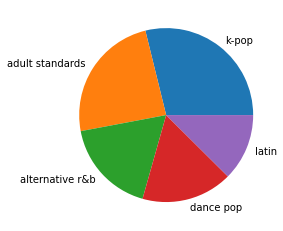

In [32]:
genre_totals = []
g_counts = []
for i in final_df['genres']:
    if i in genre_totals:
        index = genre_totals.index(i)
        g_counts[index] += 1
    else:
        genre_totals.append(i)
        g_counts.append(1)

genre_counts = pd.DataFrame(genre_totals, columns=['genre'])
genre_counts['count'] = g_counts
genre_counts = genre_counts.sort_values(by=['count'], ascending=False)
fav_genres = genre_counts[:5]
print(fav_genres)

labels = ['k-pop', 'adult standards', 'alternative r&b', 'dance pop', 'latin']
plt.pie(fav_genres['count'], labels=labels)

Since I plan on using genre as my Y value later in my ML models, I call a label encoder to label the genres with numerical values. If you are interested in the keys, the key value pairs are saved in a separate text file within ths folder. After encoding all the instances, we append the list of encoded genres to the original DataFrame. 

In [34]:
le = preprocessing.LabelEncoder()
genres = le.fit_transform(final_df['genres'])
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))

write = open("genre_keys.txt", "w")
write.write(str(dictionary))
write.close()

final_df['encoded_genre'] = genres

Lastly for EDA I will graph the daily weather and the amount of time I listen daily. The temperature graph displays a decreasing trend in average daily temperature from July to August. This makes sense because these are the months that we transition from summer to fall. Graphing the listening time, we see that there is an increase in listening time in September vs July. THis may be caused by my decreasing outdoor activities and school starting so I have more time to listen to music. It seems that there may be an inverse relationship between daily listening time and daily temperature so we will be testing the relationship between these two variables. 

Text(0.5, 1.0, 'Daily Listening Time')

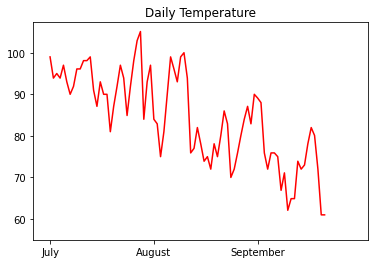

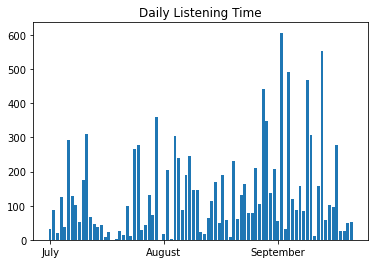

In [56]:
dates = df["date"]
temp = df["tmax"]
plt.plot(dates,temp, color="red")
plt.ylim(55)
plt.xlim(-5,95)
plt.xticks([0,31,62], ('July', 'August', 'September'))
plt.title("Daily Temperature")

x = daily_time['date']
y = daily_time['total_time']
plt.figure()
plt.bar(x, y)
plt.xticks([0,31,62], ('July', 'August', 'September'))
plt.title("Daily Listening Time")

Perhaps the most difficult part of data analysis was cleaning the dataset. There were so many issues that had to be dealt with from simply entering NaN all the way to missing parts of JSON files. Despite all of that the data that I gathered can be useful in both my hypothesis testing and ML models. 

### Hypothesis Testing

For my hypothesis I will be testing the relationship between daily average temperature and the total minutes I listen everyday. I believe that as the weather gets colder and school begins, I spend more time daily listening to music. Perhaps this is because I am more restricted to indoor activities. So I will be testing the following:

$H_0$ : In july, $\mu$ listening time < $\mu$ temperature and in September $\mu$ listening time > $\mu$ temperature

$H_1$ : In july, $\mu$ listening time > $\mu$ temperature and in September $\mu$ listening time < $\mu$ temperature

We will use a level of significane $\alpha = 0.05$  
Then we will use a 1 tailed, 2 independent sample t-test. Since we will be testing both July and September, we will be 2 seperate tests. So next lets get the data for the two months.

In [35]:
july_time = daily_time.loc[:29, 'total_time']
september_time = daily_time.loc[57:, 'total_time']
july_temp = df.loc[:32, 'tavg']
september_temp = df.loc[64:, 'tavg']

print("july:", len(july_time))
print("september:", len(september_time))

july: 30
september: 26


In [36]:
#july testing 

dof = len(july_time) - 1
print(dof)

29


Our degree of freedom return 29 and level of significance is 0.05. Based on the t-table, our t-critial is 1.69. Therefore in July, if we return with t-calculated greater than 1.69 we will reject null hypothesis.

In [37]:
t, p = stats.ttest_ind(july_time, july_temp)
print("t:", t)
if t > 1.69:
    print("Reject hypothesis")
else:
    print("Accept hypothesis")

t: 1.04983426963052
Accept hypothesis


In [38]:
dof = len(september_time) - 1
print(dof)

25


Next when we test for September our degree of freedom is 25 and the level of significance is 0.05. This makes our t-critical to be 1.708. So in our Sepember test, we should reject the null hypothesis if t-calculated is less than 1.708.

In [39]:
t, p = stats.ttest_ind(september_time, september_temp)
print("t:", t)
if t < 1.708:
    print("Reject hypothesis")
else:
    print("Accept hypothesis")

t: 3.7982055993570145
Accept hypothesis


The two tests performed above leads us to accept the null hypothesis. This concludes that I spend more time listening to music when the temperature starts to drop. There may be a number of reasons for this. However, I strongly belive that it's caused by decrease in outdoor activities and starting school. 

### ML on Artist Genre 

For ML I plan on seeing if I can predict the day's genre from the average daily temperature and the time I spent listing. I expect the model to return a low accuracy score for this because I'm more interested in seeing the correlation. As the model turns to be more accurate, we should be able to see that there are stronger relationships between the x and y attributes. In my situation however, I believe that my model will have low accuracy because I think there isn't a strong correlation between the time that I spend listening to music and the daily temperature. When I listen to music, it's more of an in the moment kind of deal rather than setting the mood based on the daily weather. 

In [41]:
daily_genres = []
prev_date = final_df[0][0]
temp_genres =[]
c = 0
def most_common(lst):
    return max(set(lst), key=lst.count)

for i in final_df[0]:
    if i == prev_date:
        temp_genres.append(final_df['encoded_genre'][c])
    else:
        if len(temp_genres) == 0:
            daily_genres.append(0)
        else:
            daily_genres.append(most_common(temp_genres))
            temp_genres = [0]
    c+=1
    prev_date = i

print(len(daily_genres))
daily_genres.append(100)

df = df.drop([3, 16, 20, 34, 36,55, 56,75], axis=0)

82


First I grab the values average temperature and time spent listening and set these as my x values. For my Y (what I will be predicting) I have the genres I listen to most everyday. 

In [42]:
temp = df['tavg']
X = pd.DataFrame(temp)
X['time'] = daily_time['total_time']
Y = daily_genres
for index, item in enumerate(Y):
    if item == 0:
        Y[index] = 109
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.33, random_state=42)
# https://github.com/davidsbatista/text-classification/issues/1 

Here we scale our x values so that we can run them through our classifiers. Without doing this, we would be working on data that are not to scale. 

In [43]:
x_train = x_train.replace(np.nan, 0)
x_test = x_test.replace(np.nan, 0)
scaler = MinMaxScaler()
scaler.fit(X)
x_train_normalized = scaler.transform(x_train)
x_test_normalized = scaler.transform(x_test)

In [52]:
knn_clf = KNeighborsClassifier(n_neighbors=20, metric="euclidean")
knn_clf.fit(x_train_normalized, y_train)
y_predicted = knn_clf.predict(x_test_normalized)
print(y_predicted)
accuracy = accuracy_score(y_test, y_predicted)
print(accuracy)

[109 109 109  11 109 109 109 109 109 109 109 109 109 109 109   3 109   3
   3 109 109 109 109 109 109   3 109 109]
0.4642857142857143


In [45]:
tree_clf = DecisionTreeClassifier(random_state=0)
tree_clf.fit(x_train_normalized, y_train)
y_predicted = tree_clf.predict(x_test_normalized)
print(y_predicted)
accuracy = accuracy_score(y_test, y_predicted)
print(accuracy)

[ 61  52 109  67  11  11  11   3 111 109  11   3  11   3  11   3 109   3
  11 109 111   3  61   3   3 109   3 109]
0.25


The first classifier I used was kNN with the number of neighbors being 20. The accuracy of this model is not that great since it is not quite 50%. The other classifier I used was decision tree which returned with a low accuracy of 25%. I would not rely on either to make predictions ont the genre that I will listen to. However, I do like to look at thses models as a way to express correlation accross data. The low accuracy of the ML predictions prove that there is little correlation between the daily temperature and listening time with the genre that I listen to on a given day. 

### Conclusion

I analyzed my Spotify streaming history and the daily weather in Spokane, Washington. This returned some interesting results in which I concluded the inverse relationship between listening time and daily temperature. My ML models also displayed that there were very low levels of correlation between my most-listened-to genre on a given day. 

This was a fun project to look at and it is something that I will definitely be tweaking in the new future. There are still an abundance of tasks and APIs that I can use based on the data I have here. Hopefully I am able to work on it more over winter break since there is a lot of potential NLP opportunities that I have yet to use since they have limitations on lyrics of songs. 